In [46]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# === Configuration ===
stocks = [
    "AMZN",        # Amazon
    "AAPL",        # Apple
    "GOOGL",       # Alphabet (Class A)
    "005930.KS",   # Samsung Electronics
    "2317.TW",     # Foxconn (Taiwan)
    "MSFT",        # Microsoft
    "JD",          # JD.com
    "BABA",        # Alibaba
    "T",           # AT&T
    "META"         # Meta (Facebook)
]

results_dir = "../results"
datasets_dir = "../datasets"

print("🟢 Stock Prediction Accuracy Analysis")
print("=" * 50)

🟢 Stock Prediction Accuracy Analysis


In [47]:
def get_actual_price(symbol, target_date):
    """Get actual closing price for a stock on a specific date"""
    try:
        df = pd.read_csv(f"{datasets_dir}/{symbol}_daily_data.csv")
        df['Date'] = pd.to_datetime(df['Date'])
        target_date_dt = pd.to_datetime(target_date)
        
        # Find the exact date or the closest business day
        matching_row = df[df['Date'] == target_date_dt]
        if not matching_row.empty:
            return matching_row['Close'].iloc[0]
        
        # If exact date not found, find the closest date after the target
        future_dates = df[df['Date'] > target_date_dt]
        if not future_dates.empty:
            return future_dates.iloc[0]['Close']
        
        return None
    except Exception as e:
        print(f"Error getting actual price for {symbol} on {target_date}: {e}")
        return None

def calculate_metrics(predicted, actual):
    """Calculate various accuracy metrics"""
    if actual == 0:
        return {
            'absolute_error': abs(predicted),
            'percentage_error': float('inf'),
            'relative_error': float('inf'),
            'accuracy': 0.0
        }
        
    absolute_error = abs(predicted - actual)
    percentage_error = (absolute_error / abs(actual)) * 100
    relative_error = ((predicted - actual) / actual) * 100
    accuracy = max(0.0, 100 - percentage_error)

    return {
        'absolute_error': absolute_error,
        'percentage_error': percentage_error,
        'relative_error': relative_error,
        'accuracy': accuracy
    }

print("✅ Helper functions defined")

✅ Helper functions defined


In [48]:
# === Process All Predictions ===
accuracy_data = []

# Get all available prediction dates
prediction_dates = []
if os.path.exists(results_dir):
    for date_folder in sorted(os.listdir(results_dir)):
        if os.path.isdir(os.path.join(results_dir, date_folder)):
            try:
                # Validate date format
                datetime.strptime(date_folder, '%Y-%m-%d')
                prediction_dates.append(date_folder)
            except ValueError:
                continue

print(f"📅 Found {len(prediction_dates)} prediction dates: {prediction_dates}")

# Process each prediction date
for pred_date in prediction_dates:
    print(f"⏳ Processing predictions for {pred_date}...")
    
    # Calculate target date (predictions are for the next day)
    pred_date_dt = datetime.strptime(pred_date, '%Y-%m-%d')
    target_date = (pred_date_dt + timedelta(days=1)).strftime('%Y-%m-%d')
    
    # Process both LSTM models
    for model_type in ['lstm', 'lstm_senti']:
        prediction_file = f"{results_dir}/{pred_date}/{model_type}.csv"
        
        if not os.path.exists(prediction_file):
            print(f"  ⚠️ Prediction file not found: {prediction_file}")
            continue
            
        pred_df = pd.read_csv(prediction_file)
        
        for _, row in pred_df.iterrows():
            symbol = row['symbol']
            predicted_price = row['predicted_price']
            
            actual_price = get_actual_price(symbol, target_date)
            
            if actual_price is not None:
                metrics = calculate_metrics(predicted_price, actual_price)
                
                if metrics:
                    result = {
                        'prediction_date': pred_date,
                        'target_date': target_date,
                        'symbol': symbol,
                        'model_type': model_type,
                        'predicted_price': predicted_price,
                        'actual_price': actual_price,
                        **metrics
                    }
                    accuracy_data.append(result)

print(f"✅ Processed {len(accuracy_data)} predictions")

# Convert to DataFrame for analysis
df_accuracy = pd.DataFrame(accuracy_data)
print(f"📊 Accuracy data shape: {df_accuracy.shape}")

📅 Found 16 prediction dates: ['2025-07-14', '2025-07-15', '2025-07-16', '2025-07-17', '2025-07-18', '2025-07-19', '2025-07-20', '2025-07-21', '2025-07-22', '2025-07-23', '2025-07-24', '2025-07-25', '2025-07-26', '2025-07-27', '2025-07-28', '2025-07-29']
⏳ Processing predictions for 2025-07-14...
⏳ Processing predictions for 2025-07-15...


⏳ Processing predictions for 2025-07-16...
⏳ Processing predictions for 2025-07-17...
⏳ Processing predictions for 2025-07-18...
⏳ Processing predictions for 2025-07-19...
⏳ Processing predictions for 2025-07-20...
⏳ Processing predictions for 2025-07-21...
⏳ Processing predictions for 2025-07-22...
⏳ Processing predictions for 2025-07-23...
⏳ Processing predictions for 2025-07-24...
⏳ Processing predictions for 2025-07-25...
⏳ Processing predictions for 2025-07-26...
⏳ Processing predictions for 2025-07-27...
⏳ Processing predictions for 2025-07-28...
⏳ Processing predictions for 2025-07-29...
✅ Processed 280 predictions
📊 Accuracy data shape: (280, 10)


In [49]:
# === Summary Statistics ===
if len(df_accuracy) > 0:
    print("\n" + "="*60)
    print("📈 OVERALL ACCURACY STATISTICS")
    print("="*60)
    
    overall_stats = {
        'Total Predictions': len(df_accuracy),
        'Mean Accuracy (%)': df_accuracy['accuracy'].mean(),
        'Median Accuracy (%)': df_accuracy['accuracy'].median(),
        'Std Accuracy (%)': df_accuracy['accuracy'].std(),
        'Mean Percentage Error (%)': df_accuracy['percentage_error'].mean(),
        'Best Accuracy (%)': df_accuracy['accuracy'].max(),
        'Worst Accuracy (%)': df_accuracy['accuracy'].min()
    }
    
    for metric, value in overall_stats.items():
        if isinstance(value, float):
            print(f"{metric}: {value:.2f}")
        else:
            print(f"{metric}: {value}")
    
    print("\n" + "="*60)
    print("🤖 ACCURACY BY MODEL TYPE")
    print("="*60)
    
    model_stats = df_accuracy.groupby('model_type').agg({
        'accuracy': ['mean', 'median', 'std', 'count'],
        'percentage_error': 'mean'
    }).round(2)
    
    print(model_stats)
    
    print("\n" + "="*60)
    print("📊 ACCURACY BY STOCK SYMBOL")
    print("="*60)
    
    symbol_stats = df_accuracy.groupby('symbol').agg({
        'accuracy': ['mean', 'median', 'std', 'count'],
        'percentage_error': 'mean'
    }).round(2)
    
    print(symbol_stats)
else:
    print("❌ No accuracy data available for analysis")


📈 OVERALL ACCURACY STATISTICS
Total Predictions: 280
Mean Accuracy (%): 98.25
Median Accuracy (%): 98.58
Std Accuracy (%): 1.53
Mean Percentage Error (%): 1.75
Best Accuracy (%): 100.00
Worst Accuracy (%): 91.12

🤖 ACCURACY BY MODEL TYPE
           accuracy                    percentage_error
               mean median   std count             mean
model_type                                             
lstm          98.17  98.46  1.56   140             1.83
lstm_senti    98.33  98.70  1.50   140             1.67

📊 ACCURACY BY STOCK SYMBOL
          accuracy                    percentage_error
              mean median   std count             mean
symbol                                                
005930.KS    97.19  97.67  2.03    28             2.81
2317.TW      98.40  99.05  1.88    28             1.60
AAPL         99.13  99.28  0.61    28             0.87
AMZN         98.17  98.08  0.84    28             1.83
BABA         97.50  98.53  2.40    28             2.50
GOOGL        

In [50]:
from tabulate import tabulate

# Load the results from CSV
df = pd.read_csv('./accuracy_analysis_results.csv')

# Calculate mean accuracy for each stock
stock_accuracy = df.groupby('symbol')['accuracy'].mean().sort_values(ascending=False)

# Show mean accuracy for each stock and model type as a table
symbol_model = df.groupby(['symbol', 'model_type'])['accuracy'].mean().unstack()
symbol_model['overall'] = df.groupby('symbol')['accuracy'].mean()
print(tabulate(symbol_model.round(2), headers="keys", tablefmt="github"))


| symbol    |   lstm |   lstm_senti |   overall |
|-----------|--------|--------------|-----------|
| 005930.KS |  97.17 |        97.2  |     97.19 |
| 2317.TW   |  98.27 |        98.53 |     98.4  |
| AAPL      |  99.17 |        99.08 |     99.13 |
| AMZN      |  98.11 |        98.24 |     98.17 |
| BABA      |  97.57 |        97.42 |     97.5  |
| GOOGL     |  98.18 |        97.61 |     97.9  |
| JD        |  98.22 |        98.25 |     98.23 |
| META      |  98.65 |        98.91 |     98.78 |
| MSFT      |  97.59 |        99.27 |     98.43 |
| T         |  98.78 |        98.78 |     98.78 |


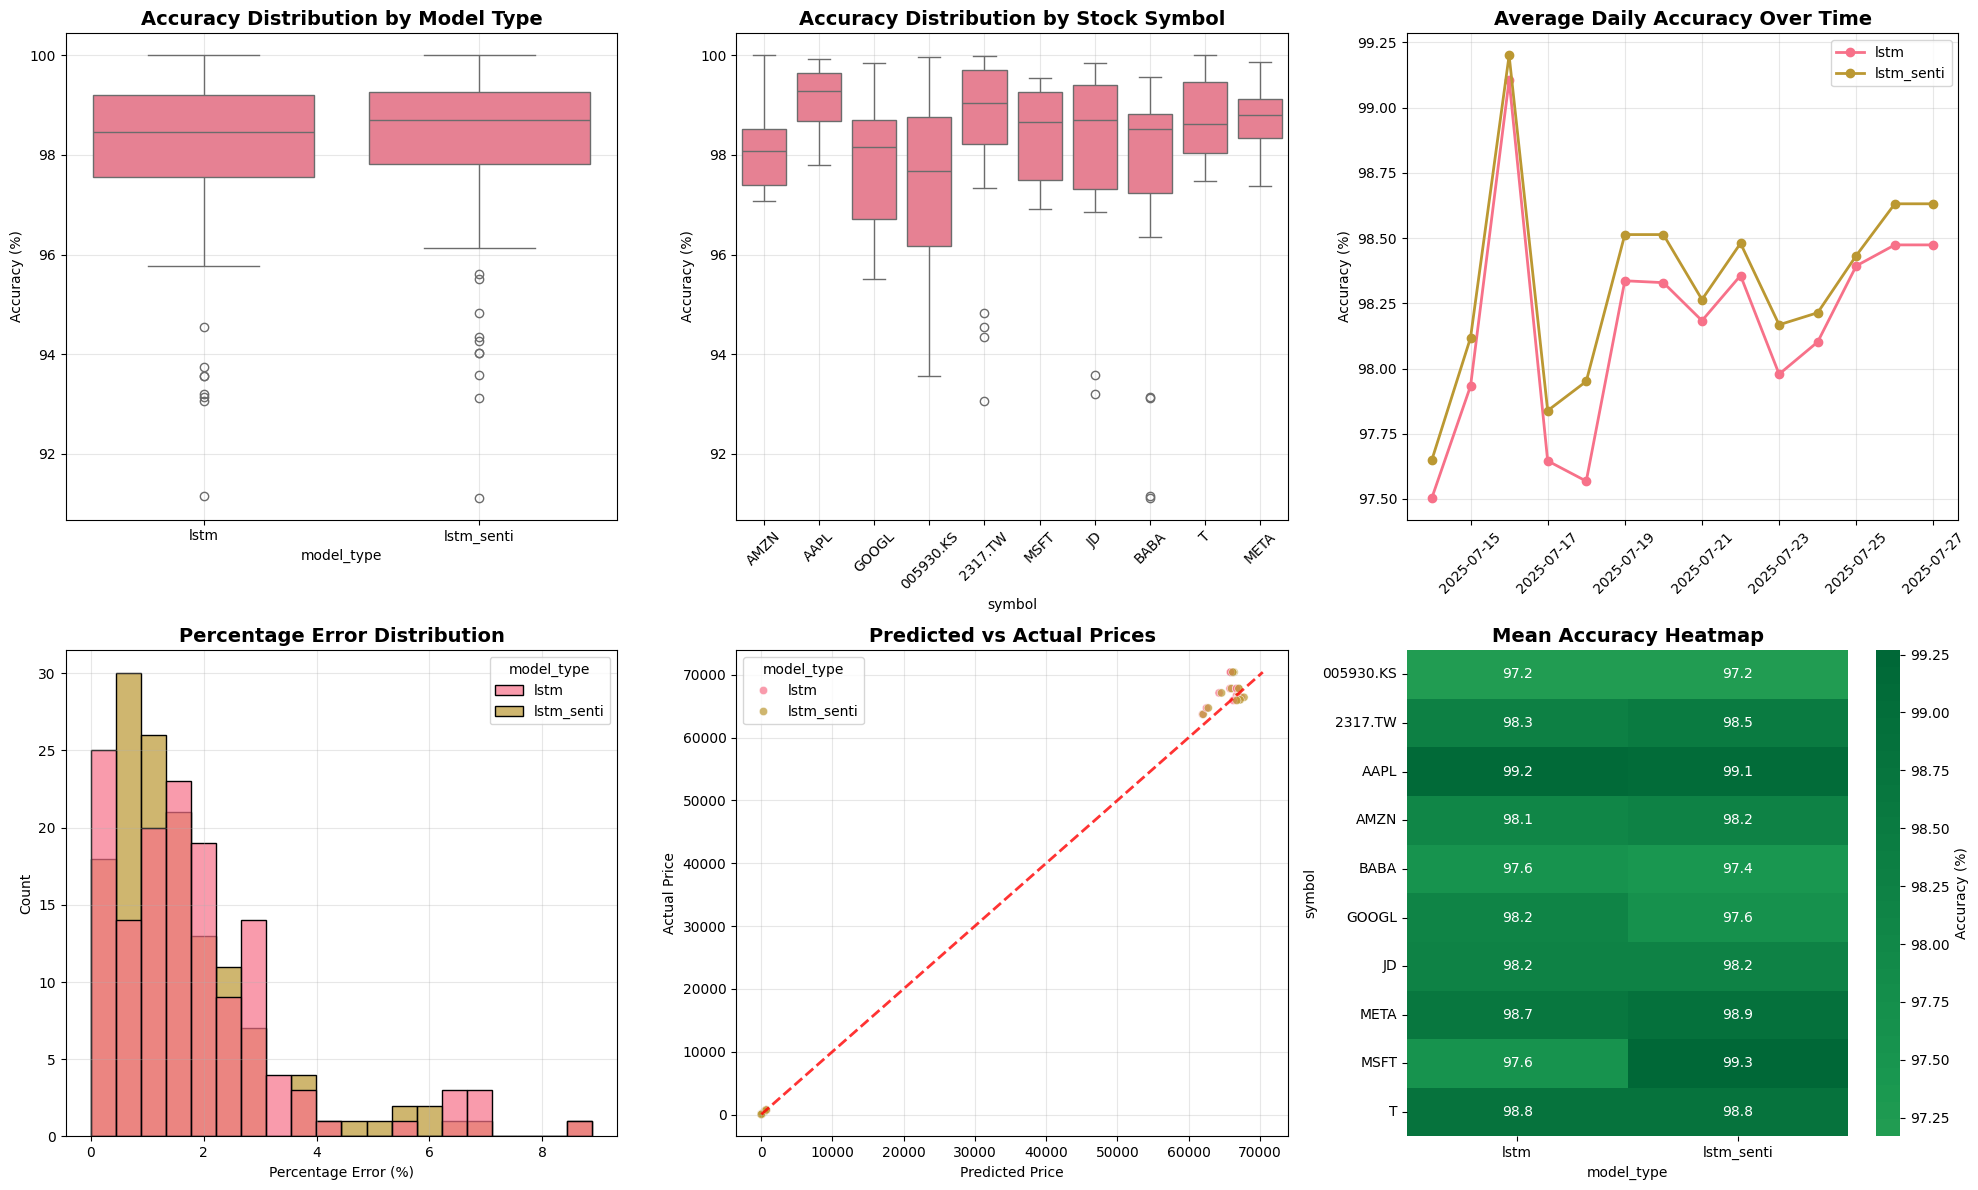

📈 Visualizations generated successfully!


In [51]:
# === Visualizations ===
if len(df_accuracy) > 0:
    # Set style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Box plot of accuracy by model
    sns.boxplot(data=df_accuracy, x='model_type', y='accuracy', ax=axes[0,0])
    axes[0,0].set_title('Accuracy Distribution by Model Type', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Accuracy (%)')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Box plot of accuracy by symbol
    sns.boxplot(data=df_accuracy, x='symbol', y='accuracy', ax=axes[0,1])
    axes[0,1].set_title('Accuracy Distribution by Stock Symbol', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Accuracy (%)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Time series of accuracy
    df_accuracy['prediction_date'] = pd.to_datetime(df_accuracy['prediction_date'])
    daily_accuracy = df_accuracy.groupby(['prediction_date', 'model_type'])['accuracy'].mean().reset_index()
    for model in daily_accuracy['model_type'].unique():
        model_data = daily_accuracy[daily_accuracy['model_type'] == model]
        axes[0,2].plot(model_data['prediction_date'], model_data['accuracy'], 
                      marker='o', linewidth=2, markersize=6, label=model)
    axes[0,2].set_title('Average Daily Accuracy Over Time', fontsize=14, fontweight='bold')
    axes[0,2].set_ylabel('Accuracy (%)')
    axes[0,2].legend()
    axes[0,2].tick_params(axis='x', rotation=45)
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Percentage error distribution
    sns.histplot(data=df_accuracy, x='percentage_error', hue='model_type', ax=axes[1,0], alpha=0.7)
    axes[1,0].set_title('Percentage Error Distribution', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Percentage Error (%)')
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Accuracy scatter plot
    sns.scatterplot(data=df_accuracy, x='predicted_price', y='actual_price', 
                   hue='model_type', alpha=0.7, ax=axes[1,1])
    # Add perfect prediction line
    min_val = min(df_accuracy['predicted_price'].min(), df_accuracy['actual_price'].min())
    max_val = max(df_accuracy['predicted_price'].max(), df_accuracy['actual_price'].max())
    axes[1,1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
    axes[1,1].set_title('Predicted vs Actual Prices', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Predicted Price')
    axes[1,1].set_ylabel('Actual Price')
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Heatmap of mean accuracy by symbol and model
    symbol_model_accuracy = df_accuracy.groupby(['symbol', 'model_type'])['accuracy'].mean().reset_index()
    symbol_model_pivot = symbol_model_accuracy.pivot(index='symbol', columns='model_type', values='accuracy')
    
    sns.heatmap(symbol_model_pivot, annot=True, fmt='.1f', cmap='RdYlGn', 
               center=90, ax=axes[1,2], cbar_kws={'label': 'Accuracy (%)'})
    axes[1,2].set_title('Mean Accuracy Heatmap', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("📈 Visualizations generated successfully!")
else:
    print("❌ No data available for visualization")

In [52]:
# === Detailed Analysis ===
if len(df_accuracy) > 0:
    print("\n" + "="*60)
    print("🔍 DETAILED ANALYSIS")
    print("="*60)
    
    # Best and worst predictions
    best_prediction = df_accuracy.loc[df_accuracy['accuracy'].idxmax()]
    worst_prediction = df_accuracy.loc[df_accuracy['accuracy'].idxmin()]
    
    print(f"\n🏆 BEST PREDICTION:")
    print(f"   Stock: {best_prediction['symbol']}")
    print(f"   Model: {best_prediction['model_type']}")
    print(f"   Date: {best_prediction['target_date']}")
    print(f"   Predicted: ${best_prediction['predicted_price']:.2f}")
    print(f"   Actual: ${best_prediction['actual_price']:.2f}")
    print(f"   Accuracy: {best_prediction['accuracy']:.2f}%")
    
    print(f"\n❌ WORST PREDICTION:")
    print(f"   Stock: {worst_prediction['symbol']}")
    print(f"   Model: {worst_prediction['model_type']}")
    print(f"   Date: {worst_prediction['target_date']}")
    print(f"   Predicted: ${worst_prediction['predicted_price']:.2f}")
    print(f"   Actual: ${worst_prediction['actual_price']:.2f}")
    print(f"   Accuracy: {worst_prediction['accuracy']:.2f}%")
    
    # Model comparison
    print(f"\n⚖️ MODEL COMPARISON:")
    model_comparison = df_accuracy.groupby('model_type').agg({
        'accuracy': 'mean',
        'percentage_error': 'mean'
    }).round(2)
    
    lstm_accuracy = model_comparison.loc['lstm', 'accuracy']
    lstm_senti_accuracy = model_comparison.loc['lstm_senti', 'accuracy']
    
    if lstm_senti_accuracy > lstm_accuracy:
        diff = lstm_senti_accuracy - lstm_accuracy
        print(f"   🎯 LSTM with Sentiment performs better by {diff:.2f}%")
    else:
        diff = lstm_accuracy - lstm_senti_accuracy
        print(f"   🎯 Basic LSTM performs better by {diff:.2f}%")
    
    # Stock-specific insights
    print(f"\n📊 STOCK-SPECIFIC INSIGHTS:")
    stock_performance = df_accuracy.groupby('symbol')['accuracy'].mean().sort_values(ascending=False)
    
    print(f"   📈 Most Predictable: {stock_performance.index[0]} ({stock_performance.iloc[0]:.2f}%)")
    print(f"   📉 Least Predictable: {stock_performance.index[-1]} ({stock_performance.iloc[-1]:.2f}%)")
    
    # Save results
    print(f"\n💾 SAVING RESULTS:")
    df_accuracy.to_csv('accuracy_analysis_results.csv', index=False)
    print("   ✅ Detailed results saved to 'accuracy_analysis_results.csv'")
    
    # Summary for easy reference
    print(f"\n" + "="*60)
    print("📋 QUICK SUMMARY")
    print("="*60)
    print(f"🎯 Overall Mean Accuracy: {df_accuracy['accuracy'].mean():.2f}%")
    print(f"📊 Total Predictions Analyzed: {len(df_accuracy)}")
    print(f"📅 Date Range: {df_accuracy['target_date'].min()} to {df_accuracy['target_date'].max()}")
    print(f"📈 Best Model: {'LSTM + Sentiment' if lstm_senti_accuracy > lstm_accuracy else 'Basic LSTM'}")
    print(f"🏆 Most Accurate Stock: {stock_performance.index[0]}")
    print("="*60)
    
else:
    print("❌ No data available for detailed analysis")


🔍 DETAILED ANALYSIS

🏆 BEST PREDICTION:
   Stock: AMZN
   Model: lstm_senti
   Date: 2025-07-16
   Predicted: $223.19
   Actual: $223.19
   Accuracy: 100.00%

❌ WORST PREDICTION:
   Stock: BABA
   Model: lstm_senti
   Date: 2025-07-15
   Predicted: $106.58
   Actual: $116.97
   Accuracy: 91.12%

⚖️ MODEL COMPARISON:
   🎯 LSTM with Sentiment performs better by 0.16%

📊 STOCK-SPECIFIC INSIGHTS:
   📈 Most Predictable: AAPL (99.13%)
   📉 Least Predictable: 005930.KS (97.19%)

💾 SAVING RESULTS:
   ✅ Detailed results saved to 'accuracy_analysis_results.csv'

📋 QUICK SUMMARY
🎯 Overall Mean Accuracy: 98.25%
📊 Total Predictions Analyzed: 280
📅 Date Range: 2025-07-15 to 2025-07-28
📈 Best Model: LSTM + Sentiment
🏆 Most Accurate Stock: AAPL


In [53]:
# === COMPREHENSIVE SUMMARY REPORT ===
from datetime import datetime
import json

def generate_summary_report():
    """Generate a comprehensive summary report of the stock prediction accuracy analysis"""
    
    if len(df_accuracy) == 0:
        print("❌ No data available for report generation")
        return
    
    # Generate timestamp for report
    report_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Prepare report data
    report_data = {
        "report_metadata": {
            "generated_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "analysis_period": f"{df_accuracy['target_date'].min()} to {df_accuracy['target_date'].max()}",
            "total_predictions": len(df_accuracy),
            "stocks_analyzed": df_accuracy['symbol'].nunique(),
            "models_compared": df_accuracy['model_type'].nunique()
        },
        
        "overall_performance": {
            "mean_accuracy_percent": round(df_accuracy['accuracy'].mean(), 2),
            "median_accuracy_percent": round(df_accuracy['accuracy'].median(), 2),
            "std_accuracy_percent": round(df_accuracy['accuracy'].std(), 2),
            "mean_percentage_error": round(df_accuracy['percentage_error'].mean(), 2),
            "best_accuracy_percent": round(df_accuracy['accuracy'].max(), 2),
            "worst_accuracy_percent": round(df_accuracy['accuracy'].min(), 2)
        },
        
        "model_comparison": {},
        "stock_performance": {},
        "key_insights": []
    }
    
    # Model comparison analysis
    model_stats = df_accuracy.groupby('model_type').agg({
        'accuracy': ['mean', 'median', 'std', 'count'],
        'percentage_error': 'mean'
    }).round(2)
    
    for model in df_accuracy['model_type'].unique():
        model_data = df_accuracy[df_accuracy['model_type'] == model]
        report_data["model_comparison"][model] = {
            "mean_accuracy": round(model_data['accuracy'].mean(), 2),
            "median_accuracy": round(model_data['accuracy'].median(), 2),
            "std_accuracy": round(model_data['accuracy'].std(), 2),
            "total_predictions": len(model_data),
            "mean_percentage_error": round(model_data['percentage_error'].mean(), 2)
        }
    
    # Stock performance analysis
    stock_performance = df_accuracy.groupby('symbol')['accuracy'].agg(['mean', 'median', 'std', 'count']).round(2)
    for symbol in stock_performance.index:
        report_data["stock_performance"][symbol] = {
            "mean_accuracy": round(stock_performance.loc[symbol, 'mean'], 2),
            "median_accuracy": round(stock_performance.loc[symbol, 'median'], 2),
            "std_accuracy": round(stock_performance.loc[symbol, 'std'], 2),
            "total_predictions": int(stock_performance.loc[symbol, 'count'])
        }
    
    # Generate key insights
    best_stock = df_accuracy.groupby('symbol')['accuracy'].mean().idxmax()
    worst_stock = df_accuracy.groupby('symbol')['accuracy'].mean().idxmin()
    best_stock_accuracy = df_accuracy.groupby('symbol')['accuracy'].mean().max()
    worst_stock_accuracy = df_accuracy.groupby('symbol')['accuracy'].mean().min()
    
    lstm_acc = report_data["model_comparison"]["lstm"]["mean_accuracy"]
    lstm_senti_acc = report_data["model_comparison"]["lstm_senti"]["mean_accuracy"]
    
    best_model = "lstm_senti" if lstm_senti_acc > lstm_acc else "lstm"
    model_improvement = abs(lstm_senti_acc - lstm_acc)
    
    report_data["key_insights"] = [
        f"Overall prediction accuracy averaged {report_data['overall_performance']['mean_accuracy_percent']}% across all stocks and models",
        f"The {best_model.replace('_', ' + ').upper()} model performed {model_improvement:.2f}% better than the alternative",
        f"Most predictable stock: {best_stock} with {best_stock_accuracy:.2f}% average accuracy",
        f"Least predictable stock: {worst_stock} with {worst_stock_accuracy:.2f}% average accuracy",
        f"Standard deviation of accuracy was {report_data['overall_performance']['std_accuracy_percent']}%, indicating {'high' if report_data['overall_performance']['std_accuracy_percent'] > 10 else 'moderate'} variability",
        f"Analysis covered {report_data['report_metadata']['total_predictions']} predictions across {report_data['report_metadata']['stocks_analyzed']} different stocks"
    ]
    
    # Generate formatted report
    report_text = f"""
╔═══════════════════════════════════════════════════════════════════════════════╗
║                         STOCK PREDICTION ACCURACY REPORT                     ║
╠═══════════════════════════════════════════════════════════════════════════════╣
║ Generated: {report_data['report_metadata']['generated_at']}                              ║
║ Period: {report_data['report_metadata']['analysis_period']}                    ║
╚═══════════════════════════════════════════════════════════════════════════════╝

📊 EXECUTIVE SUMMARY
─────────────────────
• Total Predictions Analyzed: {report_data['report_metadata']['total_predictions']:,}
• Stocks Covered: {report_data['report_metadata']['stocks_analyzed']}
• Models Compared: {report_data['report_metadata']['models_compared']}
• Overall Mean Accuracy: {report_data['overall_performance']['mean_accuracy_percent']}%
• Accuracy Range: {report_data['overall_performance']['worst_accuracy_percent']}% - {report_data['overall_performance']['best_accuracy_percent']}%

🤖 MODEL PERFORMANCE COMPARISON
─────────────────────────────────
"""
    
    for model, stats in report_data["model_comparison"].items():
        model_name = model.replace('_', ' + ').upper()
        report_text += f"""
{model_name}:
  • Mean Accuracy: {stats['mean_accuracy']}%
  • Median Accuracy: {stats['median_accuracy']}%
  • Standard Deviation: {stats['std_accuracy']}%
  • Total Predictions: {stats['total_predictions']:,}
  • Mean Error: {stats['mean_percentage_error']}%
"""
    
    report_text += f"""
📈 TOP PERFORMING STOCKS
─────────────────────────
"""
    
    # Sort stocks by performance for top 5
    sorted_stocks = sorted(report_data["stock_performance"].items(), 
                          key=lambda x: x[1]['mean_accuracy'], reverse=True)
    
    for i, (symbol, stats) in enumerate(sorted_stocks[:5], 1):
        report_text += f"{i}. {symbol}: {stats['mean_accuracy']}% (±{stats['std_accuracy']}%)\n"
    
    report_text += f"""
🔍 KEY INSIGHTS
─────────────────
"""
    
    for i, insight in enumerate(report_data["key_insights"], 1):
        report_text += f"{i}. {insight}\n"
    
    report_text += f"""

═══════════════════════════════════════════════════════════════════════════════
Report saved as: Stock_Prediction_Accuracy_Report_{report_timestamp}.txt
JSON data saved as: accuracy_analysis_summary_{report_timestamp}.json
═══════════════════════════════════════════════════════════════════════════════
"""
    
    # Save report to file
    report_filename = f"Stock_Prediction_Accuracy_Report.txt"
    with open(report_filename, 'w') as f:
        f.write(report_text)
    
    # Save JSON summary
    json_filename = f"accuracy_analysis_summary.json"
    with open(json_filename, 'w') as f:
        json.dump(report_data, f, indent=2)
    
    print(report_text)
    print(f"✅ Report saved successfully!")
    print(f"📄 Text Report: {report_filename}")
    print(f"📊 JSON Summary: {json_filename}")
    
    return report_data

# Generate the comprehensive report
summary_data = generate_summary_report()


╔═══════════════════════════════════════════════════════════════════════════════╗
║                         STOCK PREDICTION ACCURACY REPORT                     ║
╠═══════════════════════════════════════════════════════════════════════════════╣
║ Generated: 2025-07-29 06:35:37                              ║
║ Period: 2025-07-15 to 2025-07-28                    ║
╚═══════════════════════════════════════════════════════════════════════════════╝

📊 EXECUTIVE SUMMARY
─────────────────────
• Total Predictions Analyzed: 280
• Stocks Covered: 10
• Models Compared: 2
• Overall Mean Accuracy: 98.25%
• Accuracy Range: 91.12% - 100.0%

🤖 MODEL PERFORMANCE COMPARISON
─────────────────────────────────

LSTM:
  • Mean Accuracy: 98.17%
  • Median Accuracy: 98.46%
  • Standard Deviation: 1.56%
  • Total Predictions: 140
  • Mean Error: 1.83%

LSTM + SENTI:
  • Mean Accuracy: 98.33%
  • Median Accuracy: 98.7%
  • Standard Deviation: 1.5%
  • Total Predictions: 140
  • Mean Error: 1.67%

📈 TOP PERFORMI